In [1]:
%matplotlib inline
from fastai import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [5]:
# path = Path('data/mnist')
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/jupyter/.fastai/data/mnist_sample')

In [6]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_sample/models'),
 PosixPath('/home/jupyter/.fastai/data/mnist_sample/valid'),
 PosixPath('/home/jupyter/.fastai/data/mnist_sample/train'),
 PosixPath('/home/jupyter/.fastai/data/mnist_sample/labels.csv')]

In [15]:
with gzip.open('/home/jupyter/.fastai/data/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

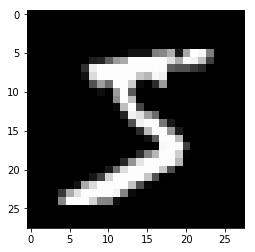

In [16]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [17]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [18]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [19]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [20]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [21]:
model = Mnist_Logistic().cuda()

In [22]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [23]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [24]:
model(x).shape

torch.Size([64, 10])

In [25]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [26]:
lr=2e-2

In [27]:
loss_func = nn.CrossEntropyLoss()

In [28]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [29]:
losses = [update(x,y,lr) for x,y in data.train_dl]

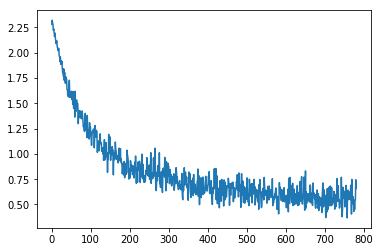

In [30]:
plt.plot(losses);

In [31]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [32]:
model = Mnist_NN().cuda()

In [33]:
losses = [update(x,y,lr) for x,y in data.train_dl]

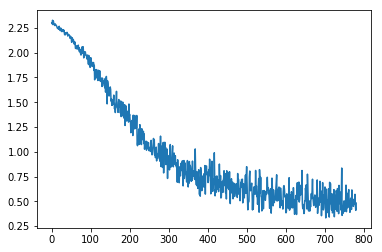

In [34]:
plt.plot(losses);

In [35]:
model = Mnist_NN().cuda()

In [36]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [37]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

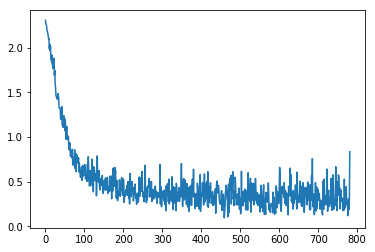

In [38]:
plt.plot(losses);

In [39]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


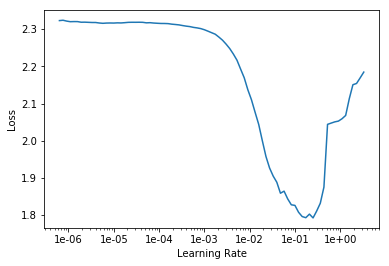

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.133975,0.123064,0.964400


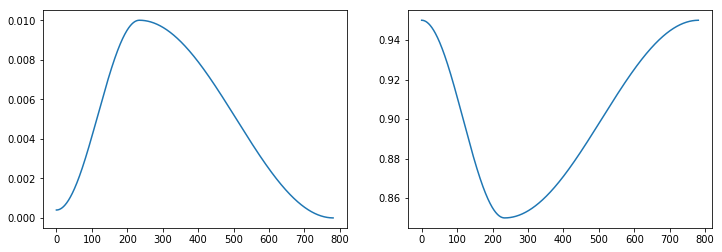

In [42]:
learn.recorder.plot_lr(show_moms=True)

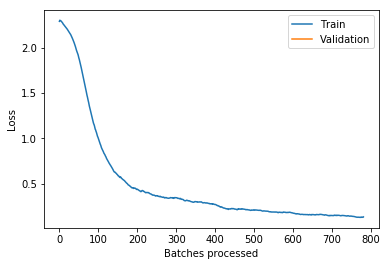

In [43]:
learn.recorder.plot_losses()

## fin